# Visium Cell Segmentation

In [1]:
import pandas as pd
import geopandas as gpd
import os 
from tifffile import imread
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon
import gc
from PIL import Image, ImageDraw
import numpy as np 

def crop_image_to_tissue(image_path, tissue_position_file, padding=10):
    """
    Crops an image around tissue coordinates specified in a parquet file.

    Parameters:
    - img: numpy array of the full-resolution image.
    - tissue_position_file: path to the directory containing 'tissue_positions.parquet'.
    - padding: number of pixels to pad around the tissue bounding box.

    Returns:
    - Cropped image (numpy array).
    """

    img = imread(image_path)

    # Load tissue positions
    df = pd.read_parquet(os.path.join(tissue_position_file, "tissue_positions.parquet"))
    df = df.set_index('barcode')
    df_tissue = df[df["in_tissue"] == 1]

    # Get coordinates
    x = df_tissue['pxl_col_in_fullres'].astype(int).values
    y = df_tissue['pxl_row_in_fullres'].astype(int).values

    # Compute padded bounding box
    x_min = max(x.min() - padding, 0)
    x_max = min(x.max() + padding, img.shape[1])
    y_min = max(y.min() - padding, 0)
    y_max = min(y.max() + padding, img.shape[0])

    # Crop image
    img_crop = img[y_min:y_max, x_min:x_max]

    # Free original image memory
    del img
    gc.collect()

    return img_crop, x_min, x_max, y_min, y_max



def segment_nuclei_and_export_gpkg(img_crop, output_path, min_percentile=5, max_percentile=95,
                                    model_name='2D_versatile_he', block_size=4096,
                                    prob_thresh=0.01, nms_thresh=0.001,
                                    min_overlap=128, context=128, n_tiles=(4,4,1)):
    """
    Segments nuclei using a pretrained StarDist2D model and saves the results as a GeoPackage.
    """
    # Load the pretrained StarDist model
    model = StarDist2D.from_pretrained(model_name)

    # Normalize the image
    img_norm = normalize(img_crop, min_percentile, max_percentile)

    # Perform instance segmentation
    labels, polys = model.predict_instances_big(
        img_norm, axes='YXC', block_size=block_size,
        prob_thresh=prob_thresh, nms_thresh=nms_thresh,
        min_overlap=min_overlap, context=context,
        normalizer=None, n_tiles=n_tiles
    )

    # Create Polygon geometries from predicted coordinates
    geometries = [
        Polygon([(y, x) for x, y in zip(coords[0], coords[1])])
        for coords in polys['coord']
    ]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=geometries)
    gdf['id'] = [f"ID_{i+1}" for i in range(len(gdf))]

    return gdf


dir_base = r'Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\visium_hd\HE_images\CRC'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
tissue_position_file = r"Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\P5_CRC\binned_outputs\square_024um\spatial"
output_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\CellCounts"
os.makedirs(output_dir, exist_ok=True)


img_crop, x_min, x_max, y_min, y_max = crop_image_to_tissue(image_path=os.path.join(dir_base, filename), tissue_position_file=tissue_position_file)

# gdf = segment_nuclei_and_export_gpkg(
#     img_crop,
#     output_path="visiumhd_output_data.gpkg"
# )
# gdf.to_file(os.path.join(output_dir,"segmentation_results", "visiumhd_output_data.gpkg"), driver="GPKG")

# # Draw Polygons
# img_pil = Image.fromarray((img_crop * 255).astype(np.uint8)) if img_crop.max() <= 1.0 else Image.fromarray(img_crop)
# draw = ImageDraw.Draw(img_pil)
# # Draw each polygon (adjust for crop offset)
# for poly in gdf.geometry:
#     shifted_coords = [(x, y) for x, y in poly.exterior.coords]
#     draw.line(shifted_coords + [shifted_coords[0]], fill='blue', width=1)
# img_pil.save(os.path.join(output_dir, "img_crop_with_polygons_fullres.png"))

### Computing Cell Stats

In [2]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt


def count_polygon_intersections(df_tissue, gdf):
    """
    For each square in df_tissue, count how many polygons in gdf intersect with it.

    Parameters:
    - df_tissue: DataFrame with 'x_min', 'x_max', 'y_min', 'y_max' columns.
    - gdf: GeoDataFrame with 'geometry' (Polygon) and 'id' columns.

    Returns:
    - result_df: DataFrame with 'num_polygons' and 'intersecting_ids' columns.
    """
    # Create square polygons from tissue bounding boxes
    df_tissue = df_tissue.copy()
    df_tissue['square_geom'] = df_tissue.apply(
        lambda row: box(row['x_min'], row['y_min'], row['x_max'], row['y_max']), axis=1
    )
    tissue_gdf = gpd.GeoDataFrame(df_tissue, geometry='square_geom')

    # Ensure same CRS (coordinate reference system)
    tissue_gdf.set_crs(gdf.crs, inplace=True)

    # Prepare results
    intersection_counts = []
    intersection_ids = []

    # Use spatial index for efficiency
    gdf_sindex = gdf.sindex

    for geom in tissue_gdf.geometry:
        possible_matches_index = list(gdf_sindex.intersection(geom.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        intersects = possible_matches[possible_matches.intersects(geom)]
        intersection_counts.append(len(intersects))
        intersection_ids.append(intersects['id'].tolist())

    # Compile result DataFrame
    result_df = pd.DataFrame({
        'num_polygons': intersection_counts,
        'intersecting_ids': intersection_ids
    }, index=df_tissue.index)

    return result_df

def get_shifted_tissue_df(bin_size, x_min, y_min,
                          microns_per_pixel=0.27369340955762717,
                          base_path=r"Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\P5_CRC\binned_outputs"):
    """
    Load and process tissue positions for a given bin size, adjusting coordinates and computing square bounds.
    Returns:
    - df_tissue: pandas DataFrame with adjusted pixel positions and bounding box columns
    """
    half_side = (bin_size / microns_per_pixel) / 2

    tissue_position_file = os.path.join(base_path, f"square_{int(bin_size):03d}um", "spatial")
    df = pd.read_parquet(os.path.join(tissue_position_file, "tissue_positions.parquet"))
    df = df.set_index('barcode')
    df_tissue = df[df["in_tissue"] == 1].copy()

    # Shift pixel coordinates relative to cropped image origin
    df_tissue['pxl_col'] = df_tissue['pxl_col_in_fullres'] - x_min
    df_tissue['pxl_row'] = df_tissue['pxl_row_in_fullres'] - y_min

    # Calculate bounding box for each square (centered at pixel coordinate)
    df_tissue['x_min'] = df_tissue['pxl_col'] - half_side
    df_tissue['x_max'] = df_tissue['pxl_col'] + half_side
    df_tissue['y_min'] = df_tissue['pxl_row'] - half_side
    df_tissue['y_max'] = df_tissue['pxl_row'] + half_side

    return df_tissue



# gdf = gpd.read_file(os.path.join(output_dir,"segmentation_results", "visiumhd_output_data.gpkg"))

# for bin_size in [8, 16, 24]:
#     df_tissue = get_shifted_tissue_df(bin_size=bin_size, x_min=x_min, y_min=y_min)
#     result_df = count_polygon_intersections(df_tissue, gdf)
#     result_path = os.path.join(output_dir, f"cell_counts_bin{bin_size}um.csv")
#     result_df.to_csv(result_path)

## Visualization Examples

#### 1. Histogram

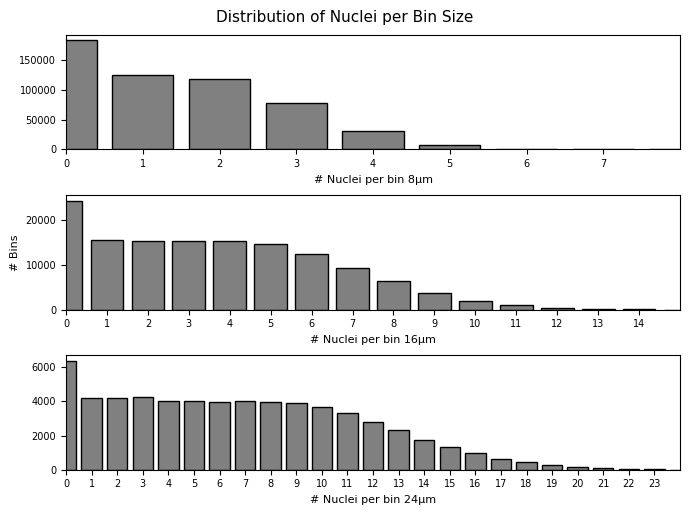

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

bin_sizes = [8, 16, 24]
output_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\CellCounts"

fig, axes = plt.subplots(3, 1, figsize=(7, 5))

for i, bin_size in enumerate(bin_sizes):
    result_path = os.path.join(output_dir, f"cell_counts_bin{bin_size}um.csv")
    result_df = pd.read_csv(result_path)
    
    max_count = result_df["num_polygons"].max()
    bins = np.arange(0, max_count + 2)  # Define proper bins

    ax = axes[i]
    counts, bin_edges = np.histogram(result_df["num_polygons"], bins=bins)

    # Keep only ticks with count >= 20
    visible_ticks = [int(bin_edges[j]) for j in range(len(counts)) if counts[j] >= 20]
    max_count = max(visible_ticks)

    ax.hist(result_df["num_polygons"], bins=bins, align='left', rwidth=0.8,
            color='gray', edgecolor='black')

    ax.set_xticks(visible_ticks)
    ax.set_xlim(left=0, right=max_count + 1)
    ax.set_title("")
    ax.set_xlabel(f'# Nuclei per bin {bin_size}μm', fontsize=8)
    
    if i == 1:
        ax.set_ylabel('# Bins', fontsize=8)

    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Distribution of Nuclei per Bin Size', fontsize=11, y=1.02)

fig.savefig(os.path.join(output_dir, "nuclei_distribution_vertical.pdf"),
            bbox_inches='tight', dpi=300)
plt.show()


#### 2. View Samples

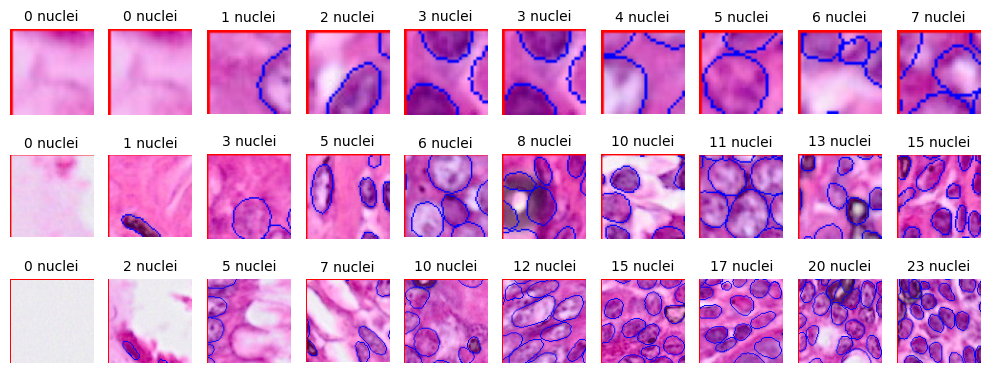

In [13]:
import os
import random
import ast
import pandas as pd
import numpy as np
import geopandas as gpd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# === Helper Functions ===
def load_data(bin_size):
    path = os.path.join(output_dir, f"cell_counts_bin{bin_size}um.csv")
    df = pd.read_csv(path)
    df['intersecting_ids'] = df['intersecting_ids'].apply(ast.literal_eval)
    return df

def extract_cropped_image(barcode, intersecting_ids, df_tissue, gdf, img_crop):
    bbox = df_tissue.loc[barcode, ["x_min", "x_max", "y_min", "y_max"]].astype(int)
    x0, x1, y0, y1 = bbox["x_min"], bbox["x_max"], bbox["y_min"], bbox["y_max"]
    crop = img_crop[y0:y1, x0:x1]

    img_pil = Image.fromarray((crop * 255).astype(np.uint8)) if crop.max() <= 1.0 else Image.fromarray(crop)
    draw = ImageDraw.Draw(img_pil)

    subset_polygons = gdf[gdf["id"].isin(intersecting_ids)]
    for poly in subset_polygons.geometry:
        coords = [(x - x0, y - y0) for x, y in poly.exterior.coords]
        draw.line(coords + [coords[0]], fill='blue', width=1)
    draw.rectangle([(0, 0), (x1 - x0, y1 - y0)], outline='red', width=1)

    return img_pil

# === Plotting Grid ===
bin_sizes = [8, 16, 24]
random_state = 10

n_samples_per_bin = 10
fig, axes = plt.subplots(len(bin_sizes), n_samples_per_bin, figsize=(10, 4))
for row_idx, bin_size in enumerate(bin_sizes):
    result_df = load_data(bin_size)
    df_tissue = get_shifted_tissue_df(bin_size=bin_size, x_min=x_min, y_min=y_min)
    gdf = gpd.read_file(os.path.join(output_dir, "segmentation_results", "visiumhd_output_data.gpkg"))

    max_cells = bin_size - 1
    selected_counts = np.linspace(0, max_cells, n_samples_per_bin, dtype=int)

    for col_idx, n_cells in enumerate(selected_counts):
        subset = result_df[result_df["num_polygons"] == n_cells]
        if subset.empty:
            axes[row_idx, col_idx].axis('off')
            continue

        row = subset.sample(n=1, random_state=random_state).iloc[0]
        barcode = row["barcode"]
        intersecting_ids = row["intersecting_ids"]

        img = extract_cropped_image(barcode, intersecting_ids, df_tissue, gdf, img_crop)
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f"{n_cells} nuclei", fontsize=10)

    axes[row_idx, 0].set_ylabel(f"Bin {bin_size}µm", fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join(output_dir, f"nuclei_distribution_examples_visiumhd_random{random_state}_n{n_samples_per_bin}.pdf"),
            bbox_inches='tight', dpi=300)
plt.show()


In [42]:
import os
import ast
import pandas as pd
import numpy as np
import geopandas as gpd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def load_data(bin_size):
    path = os.path.join(output_dir, f"cell_counts_bin{bin_size}um.csv")
    df = pd.read_csv(path)
    df['intersecting_ids'] = df['intersecting_ids'].apply(ast.literal_eval)
    return df

def extract_cropped_image(barcode, intersecting_ids, df_tissue, gdf, img_crop):
    bbox = df_tissue.loc[barcode, ["x_min", "x_max", "y_min", "y_max"]].astype(int)
    x0, x1, y0, y1 = bbox["x_min"], bbox["x_max"], bbox["y_min"], bbox["y_max"]

    # --- Skip invalid or empty crops ---
    if x0 >= x1 or y0 >= y1:
        return None
    if x0 < 0 or y0 < 0 or x1 > img_crop.shape[1] or y1 > img_crop.shape[0]:
        return None

    crop = img_crop[y0:y1, x0:x1]
    if crop.size == 0:
        return None

    img_pil = Image.fromarray((crop * 255).astype(np.uint8)) if crop.max() <= 1.0 else Image.fromarray(crop)
    draw = ImageDraw.Draw(img_pil)
    subset_polygons = gdf[gdf["id"].isin(intersecting_ids)]
    for poly in subset_polygons.geometry:
        coords = [(x - x0, y - y0) for x, y in poly.exterior.coords]
        draw.line(coords + [coords[0]], fill='blue', width=1)
    draw.rectangle([(0, 0), (x1 - x0, y1 - y0)], outline='red', width=1)
    return img_pil

# === PARAMETERS ===
bin_sizes = [8, 16, 24]
n_images = 20
random_state = 10

# Ensure output dir exists
all_output_dir = os.path.join(output_dir, "binned_examples")
os.makedirs(all_output_dir, exist_ok=True)

for bin_size in bin_sizes:
    # Load data for this bin size
    result_df = load_data(bin_size)
    df_tissue = get_shifted_tissue_df(bin_size=bin_size, x_min=x_min, y_min=y_min)
    gdf = gpd.read_file(os.path.join(output_dir, "segmentation_results", "visiumhd_output_data.gpkg"))
    
    # Prepare output directory for this bin size
    bin_out_dir = os.path.join(all_output_dir, f"bin_{bin_size}um")
    os.makedirs(bin_out_dir, exist_ok=True)
    
    # Loop over all possible n_cells
    for n_cells in range(bin_size):  # n_cells: 0, 1, ..., bin_size-1
        subset = result_df[result_df["num_polygons"] == n_cells]
        if subset.empty:
            print(f"[{bin_size}µm] No bins found with {n_cells} nuclei. Skipping.")
            continue
        n_to_plot = min(len(subset), n_images)
        subset_sampled = subset.sample(n=n_to_plot, random_state=random_state)
        
        # Grid shape (square/rectangular)
        n_cols = int(np.ceil(np.sqrt(n_to_plot)))
        n_rows = int(np.ceil(n_to_plot / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        axes = np.array(axes).reshape(-1)
        img_count = 0
        for _, row in subset_sampled.iterrows():
            barcode = row["barcode"]
            intersecting_ids = row["intersecting_ids"]
            img = extract_cropped_image(barcode, intersecting_ids, df_tissue, gdf, img_crop)
            if img is not None:
                axes[img_count].imshow(img)
                axes[img_count].axis('off')
                axes[img_count].set_title(f"{n_cells} nuclei", fontsize=10)
                img_count += 1
        # Hide extra axes
        for j in range(img_count, n_rows * n_cols):
            axes[j].axis('off')
        plt.suptitle(
            f"Bin Size: {bin_size}µm | #Nuclei per Bin: {n_cells} | #Images: {n_to_plot}",
            fontsize=16, y=1.04
        )
        plt.tight_layout()
        # Save PDF
        out_path = os.path.join(
            bin_out_dir,
            f"nuclei_binsize{bin_size}_ncells{n_cells}_n{n_to_plot}_examples.pdf"
        )
        fig.savefig(out_path, bbox_inches='tight', dpi=300)
        plt.close(fig)  # Avoid memory issues

print("Done! All images saved in", all_output_dir)


Done! All images saved in Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\CellCounts\binned_examples


## Programs per bins

1. Programs per bin 
2. Scatter programs vs neculi 

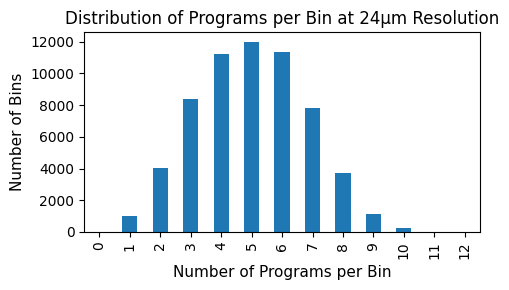

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

results_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\visiumhd_casestudy_fig8"
sample_name = "P5_CRC_GRCh38_50_24um"

usages_df = pd.read_csv(os.path.join(os.path.join(results_dir, sample_name), f"topics_per_spot_{sample_name}.csv"), index_col=0)
# === Matplotlib settings for publication ===
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 10

# === Step 1: Apply 90th percentile threshold per column ===
df_thresholded = usages_df.copy()
percentiles = df_thresholded.quantile(0.9)
df_thresholded = df_thresholded.apply(lambda col: col.where(col > percentiles[col.name], 0))

df_thresholded['n_active_programs'] = (df_thresholded > 0).sum(axis=1)
fig, ax = plt.subplots(figsize=(5, 3))
df_thresholded['n_active_programs'].value_counts().sort_index().plot(kind='bar', ax=ax)

ax.set_xlabel("Number of Programs per Bin", fontsize=11)
ax.set_ylabel("Number of Bins", fontsize=11)
ax.set_title("Distribution of Programs per Bin at 24µm Resolution", fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
fig.savefig(os.path.join(output_dir, "programs_per_bin_distribution_vertical.pdf"), 
            bbox_inches='tight', dpi=300)
plt.show()


In [15]:
bin_size = 24
output_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\crc_visiumhd_case_study\CellCounts"
result_df = pd.read_csv(os.path.join(output_dir, f"cell_counts_bin{bin_size}um.csv"), index_col=0)
result_df = result_df.join(df_thresholded['n_active_programs'])
result_df.head()

,num_polygons,intersecting_ids,n_active_programs
barcode,,,
s_024um_00000_00074-1,0,[],7.0
s_024um_00000_00075-1,0,[],6.0
s_024um_00000_00076-1,0,[],7.0
s_024um_00000_00077-1,0,[],7.0
s_024um_00000_00078-1,0,[],6.0


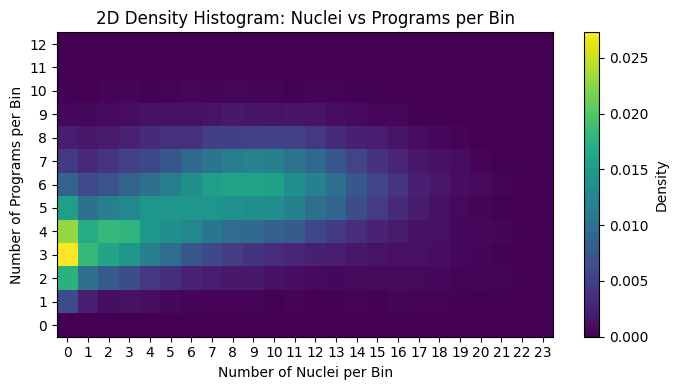

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Filtering (same as before)
mask = (
    result_df['num_polygons'].notnull() &
    result_df['n_active_programs'].notnull() &
    np.isfinite(result_df['num_polygons']) &
    np.isfinite(result_df['n_active_programs']) &
    (result_df['num_polygons'] <= 23) &
    (result_df['n_active_programs'] <= 12)
)
x = result_df.loc[mask, 'num_polygons']
y = result_df.loc[mask, 'n_active_programs']

# Bins for edges at integer values, so squares start at 0
x_bins = np.arange(0, 25, 1)   # 0 to 24 (edges)
y_bins = np.arange(0, 14, 1)   # 0 to 13 (edges)

plt.figure(figsize=(7, 4))
h = plt.hist2d(
    x, y,
    bins=[x_bins, y_bins],
    cmap='viridis',
    density=True
)

plt.colorbar(label='Density')
plt.xlabel('Number of Nuclei per Bin')
plt.ylabel('Number of Programs per Bin')
plt.title('2D Density Histogram: Nuclei vs Programs per Bin')

# Set ticks at the **center** of each square
plt.xticks(np.arange(0.5, 24, 1), labels=np.arange(0, 24, 1))
plt.yticks(np.arange(0.5, 13, 1), labels=np.arange(0, 13, 1))

plt.xlim(0, 24)
plt.ylim(0, 13)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "histogram2d_nuclei_programs_bin_density_centered.pdf"), dpi=300)
plt.show()


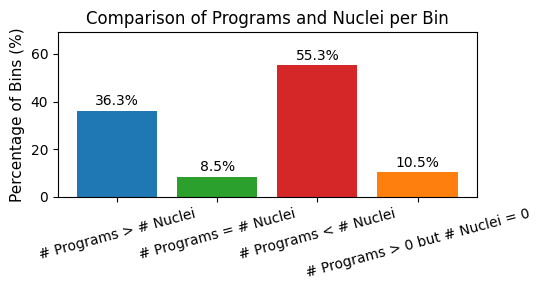

In [ ]:
import matplotlib.pyplot as plt

# Compute cases
case_gt = (result_df['n_active_programs'] > result_df['num_polygons']).sum()
case_eq = (result_df['n_active_programs'] == result_df['num_polygons']).sum()
case_lt = (result_df['n_active_programs'] < result_df['num_polygons']).sum()
case_only_programs = ((result_df['num_polygons'] == 0) & (result_df['n_active_programs'] > 0)).sum()

# Total rows
total_rows = len(result_df)

# Percentages
percent_gt = 100 * case_gt / total_rows
percent_eq = 100 * case_eq / total_rows
percent_lt = 100 * case_lt / total_rows
percent_only_programs = 100 * case_only_programs / total_rows

# Prepare data
labels = [
    "# Programs > # Nuclei",
    "# Programs = # Nuclei",
    "# Programs < # Nuclei",
    "# Programs > 0 but # Nuclei = 0"
]
percentages = [percent_gt, percent_eq, percent_lt, percent_only_programs]

# === Plot ===
fig, ax = plt.subplots(figsize=(5.5, 3))
bars = ax.bar(labels, percentages, color=["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"])

ax.set_ylabel("Percentage of Bins (%)", fontsize=11)
ax.set_title("Comparison of Programs and Nuclei per Bin", fontsize=12)
ax.set_ylim(0, max(percentages) * 1.25)
ax.tick_params(axis='x', labelrotation=15)

# Add value labels
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{percent:.1f}%", 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
fig.savefig(os.path.join(output_dir, "programs_vs_nuclei_comparison.pdf"),
            bbox_inches='tight', dpi=300)
plt.show()
